#Style Transfer by Image Reconstruction.

Implementation of paper by Gatys et al.

### Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/CV/final_project_photos

/content/drive/MyDrive/CV/final_project_photos


## Importing required libraries

In [3]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

## Creating a class for Content Loss

In [4]:
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

## Creating a class for Style Loss

In [5]:
def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    gram = torch.mm(features, features.t())
    return gram.div(a * b * c * d)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        self.loss_fn = nn.MSELoss()

    def forward(self, input):
        input_gram = gram_matrix(input)
        self.loss = self.loss_fn(input_gram, self.target)
        return input

In [6]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        normalized_img = (img - self.mean) / self.std
        return normalized_img

## Function to return model and losses

In [7]:
def get_model_loss(cnn, norm_mean, norm_std,
                               style_image, content_image,
                               content_layers=['conv_4'],
                               style_layers=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']):

    normalization = Normalization(norm_mean, norm_std)
    content_losses = []
    style_losses = []
    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_image).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_image).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [8]:
def transfer_style(cnn, norm_mean, norm_std, content_image, style_image, input_image, num_steps=300,
                       style_weight=1000000, content_weight=1):
    model, style_losses, content_losses = get_model_loss(cnn,
        norm_mean, norm_std, style_image, content_image)
    input_image.requires_grad_(True)
    model.eval()
    model.requires_grad_(False)

    optimizer = torch.optim.LBFGS([input_image])
    run = [0]
    while run[0] <= num_steps:

        def closure():
            with torch.no_grad():
                input_image.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_image)
            style_score = 0
            content_score = 0

            for style_loss in style_losses:
                style_score += style_loss.loss
            for content_loss in content_losses:
                content_score += content_loss.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 100 == 0:
                print('Style Loss: {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)
    with torch.no_grad():
        input_image.clamp_(0, 1)

    return input_image

## Miscellaneous Functions

In [9]:
def get_original_frame(tensor, content_shape):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    image = np.array(image)
    image = cv2.resize(image, (content_shape[1], content_shape[0]))
    return image

def save_image(image, name):
  im = Image.fromarray(image)
  im.save(name)

def image_loader(image_name):
    image = Image.open(image_name)
    original_shape = np.array(image).shape
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float), original_shape

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

In [11]:
imsize = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor()])

In [12]:
ext = ".jpg"
style_path = "style3"
content_path = "image11"
save_name = "./output_images/"+content_path + "_" + style_path + "_basic.jpg"

style_img, _ = image_loader("./style_images/"+style_path+".jpg")
content_img, content_shape = image_loader("./input_images/"+content_path+".jpg")

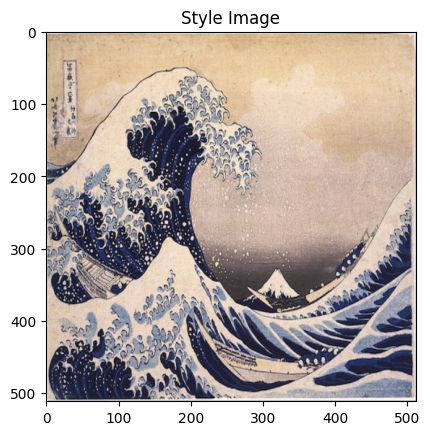

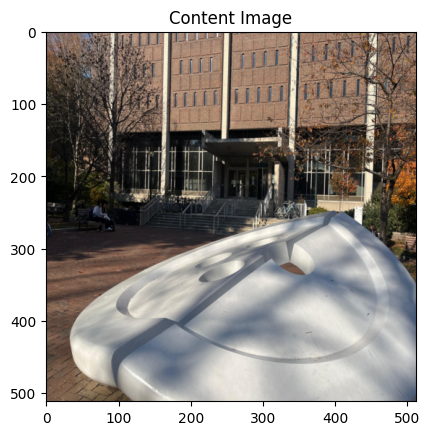

In [13]:
unloader = transforms.ToPILImage()
plt.ion()
plt.figure()
imshow(style_img, title='Style Image')
plt.figure()
imshow(content_img, title='Content Image')

/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Style Loss: 27.973291 Content Loss: 17.016613

Style Loss: 10.346389 Content Loss: 15.208572

Style Loss: 5.075206 Content Loss: 12.885326



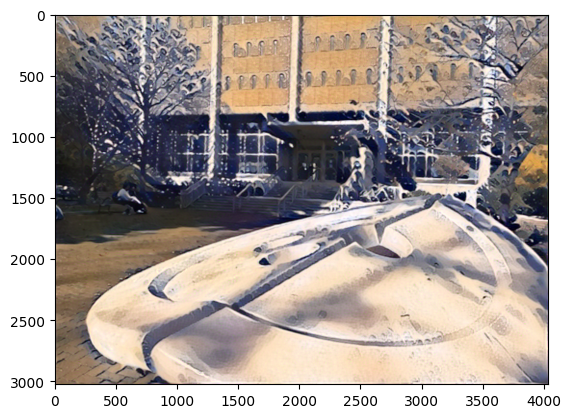

In [14]:
input_img = content_img.clone()
output = transfer_style(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

frame = get_original_frame(output, content_shape)
plt.imshow(frame)
plt.show()
save_image(frame, save_name)
plt.show()

## Extending the Style Transfer Model to work for videos.

In [15]:
cap = cv2.VideoCapture('short.mp4')
frame_interval = np.floor((1.0/24)*1000)
output_video = []
while(cap.isOpened()):
    ret, frame = cap.read()
    if frame is None:
      break
    content_shape = frame.shape
    frame = Image.fromarray(frame)
    frame = loader(frame).unsqueeze(0)
    frame = frame.to(device, torch.float)
    content_image = frame.clone()
    output = transfer_style(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_image, style_img, frame)
    output_video.append(output)
    print("Frames Processed: ",len(output_video))
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

Style Loss: 83.526917 Content Loss: 24.121468

Style Loss: 39.948906 Content Loss: 23.810356

Style Loss: 21.418251 Content Loss: 23.312048

Frames Processed:  1
Style Loss: 83.584274 Content Loss: 23.991714

Style Loss: 43.571026 Content Loss: 23.873100

Style Loss: 68.968689 Content Loss: 23.656761

Frames Processed:  2
Style Loss: 84.400879 Content Loss: 23.976105

Style Loss: 39.972618 Content Loss: 23.762768

Style Loss: 18.638252 Content Loss: 23.184071

Frames Processed:  3
Style Loss: 84.373451 Content Loss: 24.091810

Style Loss: 41.846619 Content Loss: 23.778221

Style Loss: 31.687431 Content Loss: 23.209080

Frames Processed:  4
Style Loss: 83.041779 Content Loss: 24.066093

Style Loss: 41.342201 Content Loss: 23.763393

Style Loss: 20.307621 Content Loss: 23.243881

Frames Processed:  5
Style Loss: 83.262894 Content Loss: 24.248873

Style Loss: 44.543465 Content Loss: 23.776276

Style Loss: 19.002127 Content Loss: 23.619286

Frames Processed:  6
Style Loss: 81.118591 Conten

## Saving the stylized video

In [16]:
size = content_shape[0], content_shape[1]
fps = 24
duration = len(output_video)//fps
out = cv2.VideoWriter('output_short.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (size[1], size[0]), True)
for frame in output_video:
    data = get_original_frame(frame, content_shape)

    out.write(data)
out.release()